In [1]:
setwd('/import/zhangmeixiang/daa/workflow_results/02Annotion&Express/01Annot&Exp_Annalysis/ExpAnnalysis')

In [2]:
go.cu = read.csv('./go.csv',row.names = 1)
library('ComplexHeatmap')
library('circlize')
library("RColorBrewer")
library('dplyr')
select = c('GO:0016125'
,'GO:0051054'
,'GO:0006582'
,'GO:0044550'
,'GO:0008203'
,'GO:0006749'
,'GO:0008202'
,'GO:0042440'
,'GO:0006575'
,'GO:0042180'
,'GO:0071900'
,'GO:0006631'
,'GO:0046486'
,'GO:0046470'
,'GO:0006739'
,'GO:0009262'
,'GO:0072527'
,'GO:0072593'
,'GO:0009069'
,'GO:0006534'
,'GO:0006081'
,'GO:0005759'
,'GO:0005758')

go = go.cu[select,]

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

In [3]:
diff = read.csv('diff.csv',row.names = 1)

In [4]:
upgene = diff %>% dplyr::filter(group == 'Up') %>% rownames()

add.up.info = function(x){
    a=unlist(strsplit(x, split="/"))
    number = length(intersect(a,upgene))
    return(number)
}

single <- apply(as.data.frame(go[,9]),1,add.up.info  )

In [11]:



pdf('cu.go.circos.cu.pdf',height = 9,width = 9)

go = cbind(go,up = single)

go$down = go$Count -go$up

go$gene_num.min = 0
go$gene_num.max = 1830

forcircle = go[,c(2,1,13,14,10,7,11,12,4)]

forcircle$p.adjust = -log10(forcircle$p.adjust)

colnames(forcircle) = c('ko.id','category','gene_num.min','gene_num.max','gene_num.rich','-log10.p','up.regulated','down.regulated','rich.factor')

forcircle$ko.id <- factor(rownames(forcircle), levels = rownames(forcircle))

library(circlize)
#整体布局
circos.par(gap.degree = 2, start.degree = 90)

plot_data <- forcircle[c('ko.id', 'gene_num.min', 'gene_num.max')]  #选择作图数据集，定义了 ko 区块的基因总数量范围
ko_color <- c(rep('#F7CC13', 21), rep('#954572', 52) )  #定义分组颜色 rep('#0796E0', 5)

head(plot_data)


 
circos.genomicInitialize(plot_data, plotType = NULL, major.by = 1)  #一个总布局
circos.track(
    ylim = c(0, 1), track.height = 0.05, bg.border = NA, bg.col = ko_color,  #圈图的高度、颜色等设置
    panel.fun = function(x, y) {
        ylim = get.cell.meta.data('ycenter')  #ylim、xlim 用于指定 ko id 文字标签添加的合适坐标
        xlim = get.cell.meta.data('xcenter')
        sector.name = get.cell.meta.data('sector.index')  #sector.name 用于提取 ko id 名称
        circos.axis(h = 'top', labels.cex = 1, major.tick.percentage = 0.4, labels.niceFacing = FALSE)  #绘制外周的刻度线
        circos.text(xlim, ylim, sector.name, cex = 1, niceFacing = FALSE)  #将 ko id 文字标签添加在图中指定位置处
    } )




plot_data <- forcircle[c('ko.id', 'gene_num.min', 'gene_num.rich', '-log10.p')]  #选择作图数据集，包括富集基因数量以及 p 值等信息
label_data <- forcircle['gene_num.rich']  #标签数据集，仅便于作图时添加相应的文字标识用
p_max <- round(max(forcircle$'-log10.p')) + 1  #定义一个 p 值的极值，以方便后续作图
colorsChoice <- colorRampPalette(c('#FF906F', '#861D30'))  #这两句用于定义 p 值的渐变颜色
color_assign <- colorRamp2(breaks = 0:p_max, col = colorsChoice(p_max + 1))
 
circos.genomicTrackPlotRegion(
    plot_data, track.height = 0.08, bg.border = NA, stack = TRUE,  #圈图的高度、颜色等设置
    panel.fun = function(region, value, ...) {
        circos.genomicRect(region, value, col = color_assign(value[[1]]), border = NA, ...)  #区块的长度反映了富集基因的数量，颜色与 p 值有关
        ylim = get.cell.meta.data('ycenter')  #同上文，ylim、xlim、sector.name 等用于指定文字标签（富集基因数量）添加的合适坐标
        xlim = label_data[get.cell.meta.data('sector.index'),1] / 2
        sector.name = label_data[get.cell.meta.data('sector.index'),1]
        circos.text(xlim, ylim, sector.name, cex = 0.9, niceFacing = FALSE)  #将文字标签添（富集基因数量）加在图中指定位置处
    } )


forcircle$all.regulated <- forcircle$up.regulated + forcircle$down.regulated
forcircle$up.proportion <- forcircle$up.regulated / forcircle$all.regulated
forcircle$down.proportion <- forcircle$down.regulated / forcircle$all.regulated
 
#随后，根据上下调基因的相对比例，分别计算它们在作图时的“区块坐标”和“长度”
forcircle$up <- forcircle$up.proportion * forcircle$gene_num.max
plot_data_up <- forcircle[c('ko.id', 'gene_num.min', 'up')]
names(plot_data_up) <- c('ko.id', 'start', 'end')
plot_data_up$type <- 1  #分配 1 指代上调基因
 
forcircle$down <- forcircle$down.proportion * forcircle$gene_num.max + forcircle$up
plot_data_down <- forcircle[c('ko.id', 'up', 'down')]
names(plot_data_down) <- c('ko.id', 'start', 'end')
plot_data_down$type <- 2  #分配 2 指代下调基因
 
#选择作图数据集（作图用）、标签数据集（添加相应的文字标识用），并分别为上下调基因赋值不同颜色
plot_data <- rbind(plot_data_up, plot_data_down)
label_data <- forcircle[c('up', 'down', 'up.regulated', 'down.regulated')]
color_assign <- colorRamp2(breaks = c(1, 2), col = c('#671166', '#7F8CCB'))


#继续绘制圈图
circos.genomicTrackPlotRegion(
    plot_data, track.height = 0.08, bg.border = NA, stack = TRUE,  #圈图的高度、颜色等设置
    panel.fun = function(region, value, ...) {
        circos.genomicRect(region, value, col = color_assign(value[[1]]), border = NA, ...)  #这里紫色代表上调基因，蓝色代表下调基因，区块的长度反映了上下调基因的相对占比
        ylim = get.cell.meta.data('cell.bottom.radius') - 0.5  #同上文，ylim、xlim、sector.name 等用于指定文字标签（上调基因数量）添加的合适坐标
        xlim = label_data[get.cell.meta.data('sector.index'),1] / 2
        sector.name = label_data[get.cell.meta.data('sector.index'),3]
        circos.text(xlim, ylim, sector.name, cex = 1, niceFacing = FALSE)  #将文字标签（上调基因数量）添加在图中指定位置处
        xlim = (label_data[get.cell.meta.data('sector.index'),2]+label_data[get.cell.meta.data('sector.index'),1]) / 2
        sector.name = label_data[get.cell.meta.data('sector.index'),4]
        circos.text(xlim, ylim, sector.name, cex = 0.8, niceFacing = FALSE)  #类似的操作，将下调基因数量的标签也添加在图中
    } )


plot_data <- forcircle[,c('ko.id', 'gene_num.min', 'gene_num.max', 'rich.factor')]  #选择作图数据集，包含富集因子列


label_data <- forcircle['category']  #将通路的分类信息提取出，和下一句一起，便于作图时按分组分配颜色
color_assign <- c('BP' = '#F7CC13',
                 
                  'CC' = '#954572') # 'MF' ='#0796E0',

library(DOSE)
plot_data$rich.factor<- parse_ratio(plot_data$rich.factor)*20

circos.genomicTrack(
    plot_data, ylim = c(0, 1), track.height = 0.3, bg.col = 'gray95', bg.border = NA,  #圈图的高度、颜色等设置
    panel.fun = function(region, value, ...) {
        sector.name = get.cell.meta.data('sector.index')  #sector.name 用于提取 ko id 名称，并添加在下一句中匹配 ko 对应的高级分类，以分配颜色
        circos.genomicRect(region, value, col = color_assign[label_data[sector.name,1]], border = NA, ytop.column = 1, ybottom = 0, ...)  #绘制矩形区块，高度代表富集因子数值，颜色代表 ko 的分类
        circos.lines(c(0, max(region)), c(0.5, 0.5), col = 'gray', lwd = 0.3)  #可选在富集因子等于 0.5 的位置处添加一个灰线
    } )
 
# ##绘图完毕后，不要忘了清除痕迹，以免影响下一次作图
circos.clear()







library(ComplexHeatmap)
 
category_legend <- Legend(
    labels = c('BP',  'CC'),  #'MF',
    type = 'points', pch = NA, background = c('#F7CC13', '#954572', '#0796E0'), 
    labels_gp = gpar(fontsize = 8), grid_height = unit(0.5, 'cm'), grid_width = unit(0.5, 'cm'))
 
updown_legend <- Legend(
    labels = c('Up-regulated', 'Down-regulated'), 
    type = 'points', pch = NA, background = c('#671166', '#7F8CCB'), 
    labels_gp = gpar(fontsize = 8), grid_height = unit(0.5, 'cm'), grid_width = unit(0.5, 'cm'))
 
pvalue_legend <- Legend(
    col_fun = colorRamp2(round(seq(0, p_max, length.out = 6), 0), 
    colorRampPalette(c('#FF906F', '#861D30'))(6)),
    legend_height = unit(3, 'cm'), labels_gp = gpar(fontsize = 8), 
    title_gp = gpar(fontsize = 9), title_position = 'topleft', title = '-Log10(Pvalue)')
 
lgd_list_vertical <- packLegend(category_legend, updown_legend, pvalue_legend)


p2 = grid.draw(lgd_list_vertical)
dev.off()

,ko.id,gene_num.min,gene_num.max
,<fct>,<dbl>,<dbl>
GO:0016125,GO:0016125,0,1830
GO:0051054,GO:0051054,0,1830
GO:0006582,GO:0006582,0,1830
GO:0044550,GO:0044550,0,1830
GO:0008203,GO:0008203,0,1830
GO:0006749,GO:0006749,0,1830


`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not used any more, please directly use argument `major.tick.length`.

`major.tick.percentage` is not

png 
  2

In [2]:
data = read.csv('./expr.csv',row.names = 1)

In [3]:
cu.gene = read.csv('./cu.csv',header =F,row.names = 1)

In [4]:
data1 = data[rownames(cu.gene),]

In [5]:
library(pheatmap)

forplot = na.omit(data1)

#forplot = forplot[rowSums(forplot) >100,]

#da=log2(data1+1)
dat=t(scale(t(forplot))) # 'scale'可以对log(fpkm+1)数值进行归一化
#处理数据
dat[dat>2]=2
dat[dat<(-2)]= -2
dim(dat)

dat = dat[complete.cases(dat), ]

Warning message:
"package 'pheatmap' was built under R version 4.2.3"


[1] 34  6

In [6]:
library(pheatmap)
annotation_col = data.frame(c(rep('Control',3),rep('Fe-MoS2 + US + H2O2',3)))
colnames(annotation_col) = 'group'
row.names(annotation_col) <- colnames(dat)
head(dat,2)

,C_1,C_2,C_3,FHU_1,FHU_2,FHU_3
Hmox1,-0.9051991,-0.9201139,-0.9131801,0.9247132,0.8993511,0.9144288
Srxn1,-0.9188818,-0.9052318,-0.9136060,0.8776342,0.9558771,0.9042083


In [7]:
#dat2 = dat[-c(1:8),]

In [8]:
cu.gene

,V2,V3
,<chr>,<chr>
Hmox1,response to oxidative stress,Oxidative stress
Srxn1,response to oxidative stress,Oxidative stress
Slc7a11,response to oxidative stress,Oxidative stress
Nqo1,response to oxidative stress,Oxidative stress
Txnip,response to oxidative stress,Oxidative stress
Gclm,response to oxidative stress,Oxidative stress
Met,cellular response to oxidative stress,Oxidative stress
Ect2,cellular response to oxidative stress,Oxidative stress
G6pdx,cellular response to oxidative stress,Oxidative stress


In [9]:
colnames(cu.gene) = c('Pathway','Type')

In [10]:
dat2 = dat

In [11]:
dim(dat2)

[1] 34  6

In [12]:
dim(cu.gene)

[1] 34  2

In [27]:

BPcolor <- rev(c("#FDE3D6",'#C5DFB3'))
names(BPcolor) <- c("Oxidative stress","Cuproptosis-like")

In [28]:
Pathcolor <- colorRampPalette(c("#405761",'#F8841C'))(9)

In [39]:
Pathcolor = rev(c('#E1714C','#ED7E68','#EE9480','#F5BEB0','#F8DCD1','#89AF7C','#24736D','#234351','#3F5D65'))

In [40]:
names(Pathcolor) <- unique(cu.gene$Pathway)

In [41]:
unique(cu.gene$Pathway)

[1] "response to oxidative stress"         
[2] "cellular response to oxidative stress"
[3] "antioxidant activity"                 
[4] "Glutathione metabolism"               
[5] "response to copper ion"               
[6] "Glycolysis / Gluconeogenesis"         
[7] "amino acid metabolism"                
[8] "purine metabolism"                    
[9] "TCA cycle"

In [42]:
ann_colors <- list( Type=BPcolor,Pathway= Pathcolor)

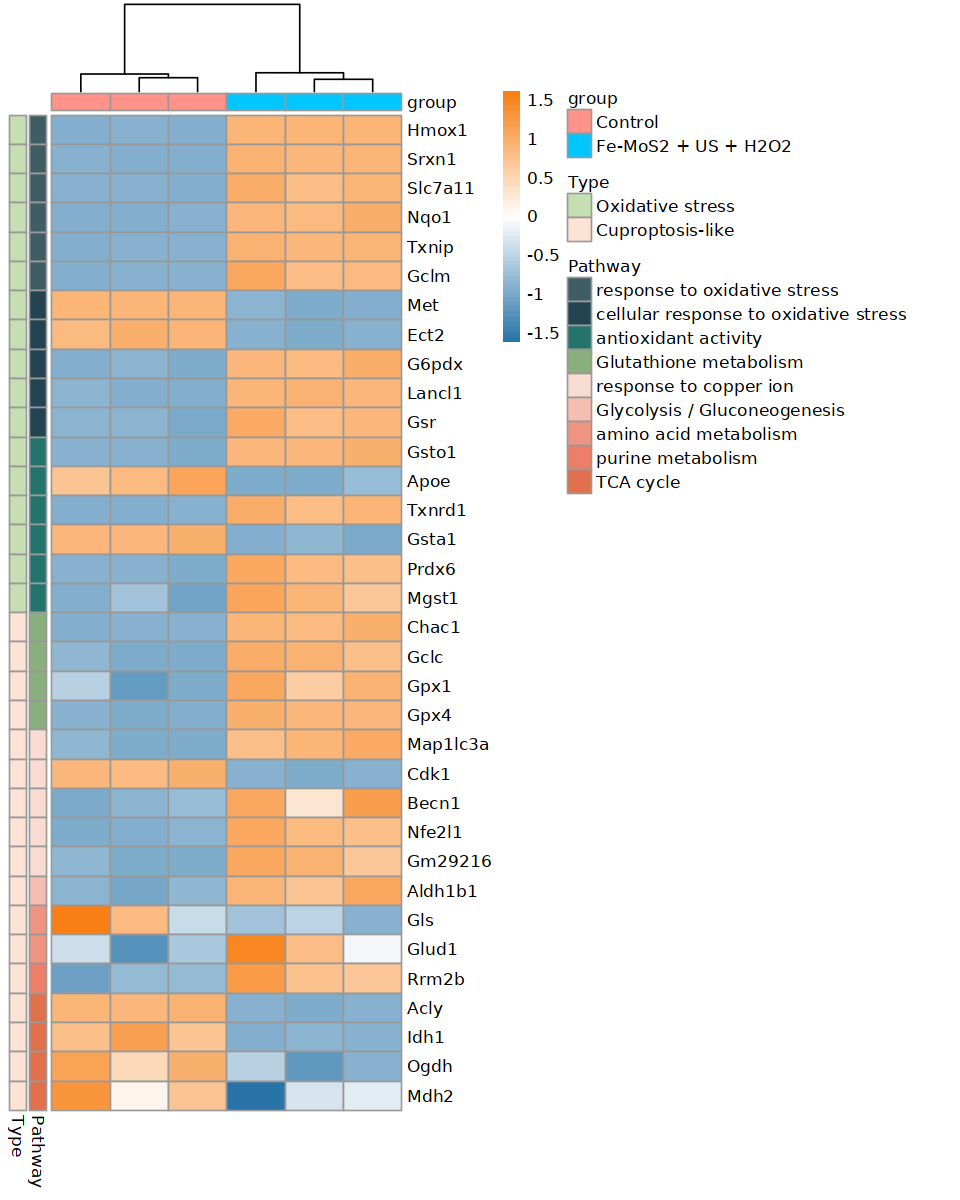

In [43]:

options(repr.plot.width = 8,repr.plot.height = 10)
xx = pheatmap(dat2,
         cluster_rows = FALSE,
         cluster_cols = TRUE,
         show_rownames=TRUE,
         show_colnames = FALSE,
          scale="none", annotation_colors  = ann_colors,
        annotation_col = annotation_col,
              annotation_row = cu.gene,
          #cluster_cols = F,
          fontsize_row = 10,
          fontsize_col = 10,
          #color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
          color = colorRampPalette(c("#2874A9", "white", "#F87F13"))(100)#换颜色
         # angle_col = 45 #修改横轴坐标名倾斜度
)

In [45]:
pdf('cu.gene.pdf',height =6
    ,width = 6)
xx
dev.off()

png 
  2

In [25]:
dat1 =dat[1:8,]

In [54]:
options(repr.plot.width = 5,repr.plot.height = 4)
xx = pheatmap(dat1,
         cluster_rows = FALSE,
         cluster_cols = TRUE,
         show_rownames=TRUE,
         show_colnames = FALSE,
          scale="none",
        annotation_col = annotation_col,
             # annotation_row = cu.gene,
          #cluster_cols = F,
          fontsize_row = 10,
          fontsize_col = 10,
          #color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
          color = colorRampPalette(c("#2874A9", "white", "#F87F13"))(100)#换颜色
         # angle_col = 45 #修改横轴坐标名倾斜度
)

ERROR: Error in rownames(mat): object 'dat1' not found


In [35]:
pdf('cu.gene.2.pdf',height = 3,width = 5)
xx
dev.off()

png 
  2

In [40]:
data = read.csv('./expr.csv',row.names = 1)